<a href="https://colab.research.google.com/github/samlucas28/Thesis-python-scripts/blob/main/Decision_tree_SA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



=== SCENARIO ANALYSES RESULTS FOR FULL COHORT ===
  Total cost (for 50000 women): £2325886.22
  Total symptomatic cases: 785.75
  Total moderate risk cases: 710.38
  Total high risk cases: 68.97
  Total cost (for 50000 women): £931312.69
  Total symptomatic cases: 809.79
  Total moderate risk cases: 9.49
  Total high risk cases: 2.18

=== SCENARIO ANALYSIS RESULTS STRATIFIED BY IMD ===
  Total expected for 5002 women in IMD 1:
    SEND_TEXT total cost: £229874.57
    SEND_TEXT total symptomatic cases: 79.65
    SEND_TEXT total moderate risk cases: 40.52
    SEND_TEXT total high risk cases: 3.93
    SEND_TEXT total MODERATE + HIGH risk cases: 44.45
    NO_TEXT total cost: £93074.88
    NO_TEXT total symptomatic cases: 81.02
    NO_TEXT total moderate risk cases: 0.53
    NO_TEXT total high risk cases: 0.12
    NO_TEXT total MODERATE + HIGH risk cases: 0.65
  Total expected for 4977 women in IMD 2:
    SEND_TEXT total cost: £229458.57
    SEND_TEXT total symptomatic cases: 78.98
    SEN

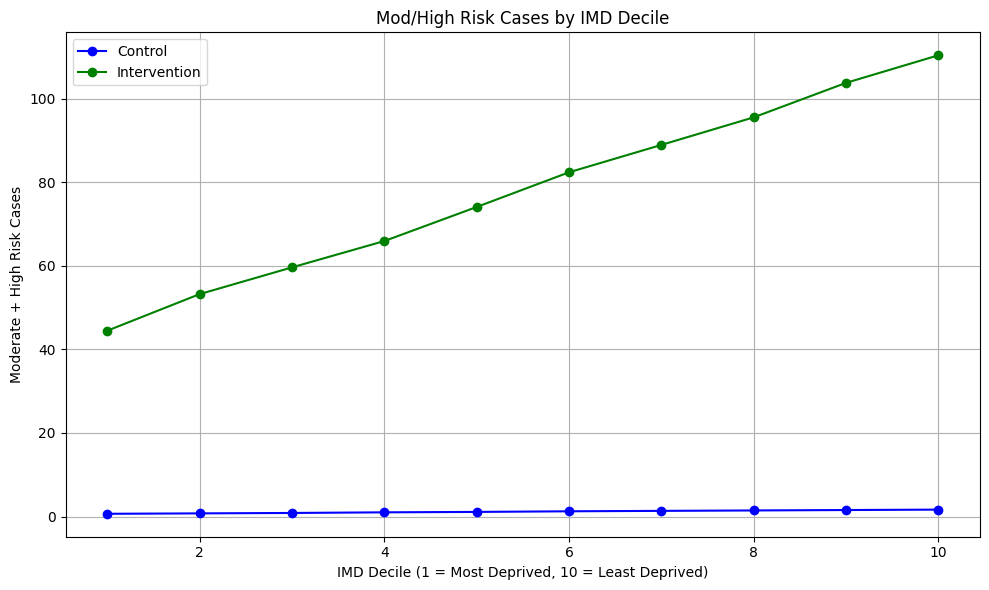

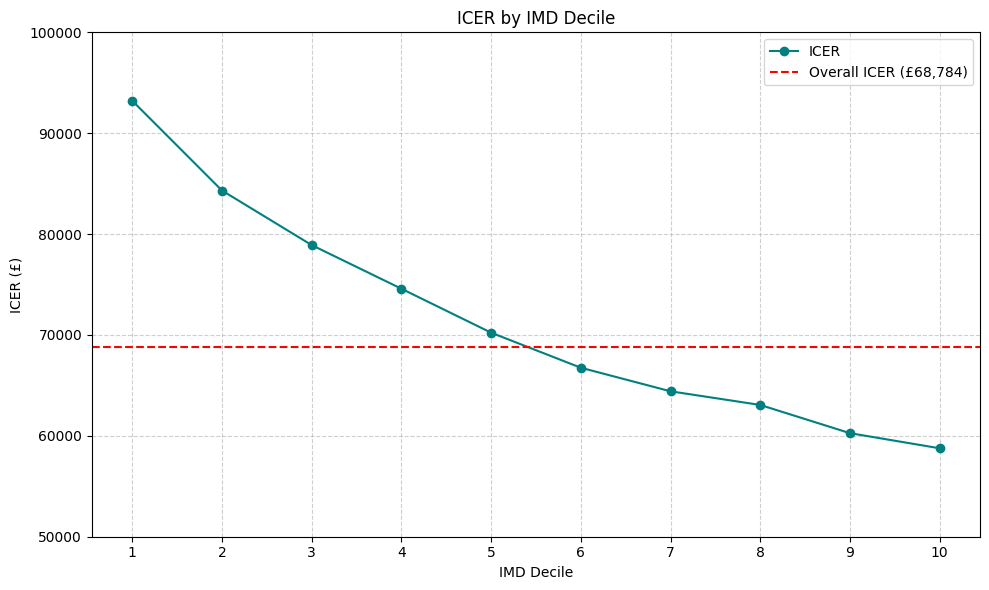

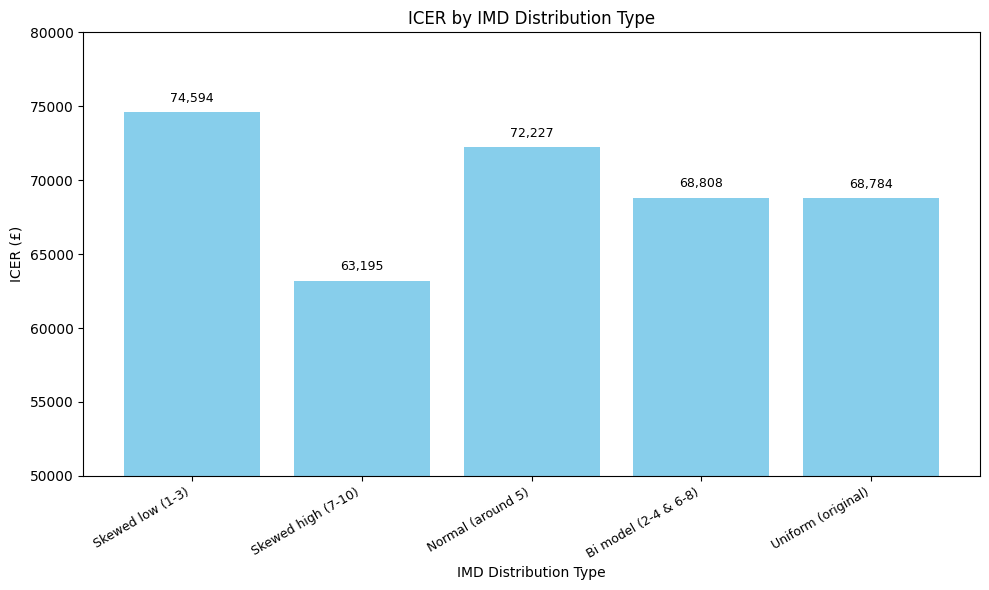

In [ ]:
# -----------------------------------------
# DECISION TREE FOR SCENARIO ANALYSES
# -----------------------------------------

from __future__ import annotations
from dataclasses import dataclass
from typing import Dict, List, Tuple, Callable, Union
import numpy as np
from scipy.stats import beta, gamma, dirichlet, lognorm
import pandas as pd

# 1. DEFINING THE COHORT
# -----------------------------
rng = np.random.default_rng(seed=1)
N = 50000 # Cohort size


cohort = pd.DataFrame({
    "start_age": rng.integers(38, 46, N),  # Random ages from 38 to 45
    "imd": rng.integers(1, 11, N)          # IMD based on normal distribution (can change for varying distributions)
})

# 2. DISTRIBUTIONS
# -----------------------------
def dist_lognormal(mu_l: float, sigma_l: float):
    return lognorm(s=sigma_l, scale=np.exp(mu_l))

def dist_beta(a: float, b: float):
    return beta(a, b)

def dist_gamma(k: float, rate: float):
    return gamma(k, scale=1 / rate)

def dist_dirichlet(alphas: List[float]):
    return dirichlet(alphas)

# 3. PARAMETERS
# -----------------------------
PARAMS: Dict[str, Union[float, Tuple, list, Callable]] = {
    "COST_FHQS_TEXT":        dist_lognormal(3.091, 0.618),
    "COST_UPTAKE":           dist_gamma(32.83, 3.29),
    "COST_SYMPTOM":          dist_gamma(894.8, 0.780),
    "COST_HIGH_RISK":        351.88,
    "COST_REFERRAL":         66.93,

    "P_FHQS_UPTAKE":         dist_beta(203, 1277),
    "P_RISK_SPLIT_FHQS":     dist_dirichlet([88.7, 10.3, 1.0]),

    "P_SYMPT_LOWRISK":       dist_beta(35008, 2413112),
    "P_SYMPT_UNCLASSIFIED":  dist_beta(44712, 2715288),

    "IMD_REFERRAL": {
        i: dist_beta(a, b) for i, (a, b) in {
            1: (5, 19224), 2: (17, 56094), 3: (24, 67475), 4: (27, 67777),
            5: (40, 89535), 6: (60, 119543), 7: (58, 107788), 8: (65, 111408),
            9: (71, 112480), 10: (60, 89261)
        }.items()
    },

    "P_RISK_SPLIT_REFERRAL": dist_dirichlet([50.3, 40.4, 9.3]),
}

# 4. NODE CLASSES
# -----------------------------
@dataclass
class Node:
    def expected_cost(self) -> float: raise NotImplementedError
    def expected_outcomes(self) -> dict: raise NotImplementedError
    def simulate(self, deterministic=False) -> Tuple[float, dict, str]: raise NotImplementedError

@dataclass
class Terminal(Node):
    cost: Union[float, Callable[[], float]]
    label: str = "TERMINAL"

    def get_cost(self, deterministic=False) -> float:
        if deterministic:
            if callable(self.cost) and hasattr(self.cost, "mean"):
                return self.cost.mean()
            elif callable(self.cost):
                return self.cost()
        return self.cost() if callable(self.cost) else self.cost

    def expected_cost(self) -> float:
        return self.get_cost(deterministic=True)

    def expected_outcomes(self) -> dict:
        return {
            'symptomatic': int(self.label == "SYMPT_PRESENT"),
            'moderate': int(self.label == "MODERATE_RISK"),
            'high': int(self.label == "HIGH_RISK"),
        }

    def simulate(self, deterministic=False) -> Tuple[float, dict, str]:
        return self.get_cost(deterministic), self.expected_outcomes(), self.label

@dataclass
class Chance(Node):
    branches: List[Tuple[Callable[[], float], Node]]

    def expected_cost(self) -> float:
        return sum(p() * node.expected_cost() for p, node in self.branches)

    def expected_outcomes(self) -> dict:
        outcomes = {'symptomatic': 0, 'moderate': 0, 'high': 0}
        for p, node in self.branches:
            prob = p()
            child_outcomes = node.expected_outcomes()
            for k in outcomes:
                outcomes[k] += prob * child_outcomes[k]
        return outcomes

    def simulate(self, deterministic=False) -> Tuple[float, dict, str]:
        probs = np.array([p() for p, _ in self.branches])
        probs /= probs.sum()
        choice = np.random.choice(len(self.branches), p=probs)
        return self.branches[choice][1].simulate(deterministic)

@dataclass
class Decision(Node):
    options: Dict[str, Node]

    def expected_cost(self, option: str) -> float:
        return self.options[option].expected_cost()

    def expected_outcomes(self, option: str) -> dict:
        return self.options[option].expected_outcomes()

    def simulate(self, option: str, deterministic=False) -> Tuple[float, dict, str]:
        return self.options[option].simulate(deterministic)

@dataclass
class AddCost(Node):
    cost: Union[float, Callable[[], float]]
    next_node: Node

    def get_cost(self, deterministic=False) -> float:
        if deterministic:
            if callable(self.cost) and hasattr(self.cost, "mean"):
                return self.cost.mean()
            elif callable(self.cost):
                return self.cost()
        return self.cost() if callable(self.cost) else self.cost

    def expected_cost(self) -> float:
        return self.get_cost(deterministic=True) + self.next_node.expected_cost()

    def expected_outcomes(self) -> dict:
        return self.next_node.expected_outcomes()

    def simulate(self, deterministic=False) -> Tuple[float, dict, str]:
        cost_now = self.get_cost(deterministic)
        cost_next, outcomes, label = self.next_node.simulate(deterministic)
        return cost_now + cost_next, outcomes, label

# 5. TREE CONSTRUCTION
# -----------------------------
def make_tree(imd_decile: int, deterministic=False,
              override_p_fhqs_uptake=None,
              override_cost_fhqs_text=None,
              override_cost_symptom=None) -> Decision:

    def get_val(d):
        return d.mean() if deterministic and hasattr(d, "mean") else d.rvs() if hasattr(d, "rvs") else d

    no_sympt = Terminal(0.0, "NO_SYMPT_PRESENT")
    sympt = Terminal(override_cost_symptom or get_val(PARAMS["COST_SYMPTOM"]), "SYMPT_PRESENT")
    mod_risk = Terminal(0.0, "MODERATE_RISK")
    high_risk = Terminal(get_val(PARAMS["COST_HIGH_RISK"]), "HIGH_RISK")

    def make_sympt_node(dist):
        p = get_val(dist)
        return Chance([
            (lambda p=p: p, sympt),
            (lambda p=p: 1 - p, no_sympt)
        ])

    low_risk_sympt = make_sympt_node(PARAMS["P_SYMPT_LOWRISK"])
    unclass_sympt = make_sympt_node(PARAMS["P_SYMPT_UNCLASSIFIED"])

    def dirichlet_probs(d):
        if deterministic:
            alpha = d.alpha
            return tuple(a / sum(alpha) for a in alpha)
        return tuple(d.rvs()[0])

    def fhqs_risk_node():
        p_low, p_mod, p_high = dirichlet_probs(PARAMS["P_RISK_SPLIT_FHQS"])
        return Chance([
            (lambda p=p_low: p, low_risk_sympt),
            (lambda p=p_mod: p, mod_risk),
            (lambda p=p_high: p, high_risk),
        ])

    def referral_risk_node():
        p_low, p_mod, p_high = dirichlet_probs(PARAMS["P_RISK_SPLIT_REFERRAL"])
        return Chance([
            (lambda p=p_low: p, low_risk_sympt),
            (lambda p=p_mod: p, mod_risk),
            (lambda p=p_high: p, high_risk),
        ])

    p_uptake = override_p_fhqs_uptake if override_p_fhqs_uptake is not None else get_val(PARAMS["P_FHQS_UPTAKE"])
    cost_uptake = get_val(PARAMS["COST_UPTAKE"])
    cost_text = override_cost_fhqs_text if override_cost_fhqs_text is not None else get_val(PARAMS["COST_FHQS_TEXT"])
    p_referral = get_val(PARAMS["IMD_REFERRAL"][imd_decile])
    cost_referral = get_val(PARAMS["COST_REFERRAL"])

    uptake_node = Chance([
        (lambda: p_uptake, AddCost(lambda: cost_uptake, fhqs_risk_node())),
        (lambda: 1 - p_uptake, unclass_sympt)
    ])

    send_text_node = AddCost(lambda: cost_text, uptake_node)

    referral_node = Chance([
        (lambda: p_referral, AddCost(lambda: cost_referral, referral_risk_node())),
        (lambda: 1 - p_referral, unclass_sympt)
    ])

    return Decision({
        "SEND_TEXT": send_text_node,
        "NO_TEXT": referral_node,
    })

# 6. EVALUATE TREE
# -----------------------------
def evaluate_tree(imd: int, p_fhqs_uptake=None, cost_fhqs_text=None, cost_symptom=None):
    tree = make_tree(imd, deterministic=True,
                     override_p_fhqs_uptake=p_fhqs_uptake,
                     override_cost_fhqs_text=cost_fhqs_text,
                     override_cost_symptom=cost_symptom)
    return {
        "SEND_TEXT": {
            "cost": tree.expected_cost("SEND_TEXT"),
            **tree.expected_outcomes("SEND_TEXT")
        },
        "NO_TEXT": {
            "cost": tree.expected_cost("NO_TEXT"),
            **tree.expected_outcomes("NO_TEXT")
        }
    }

# 7. FHQS uptake probabilities by IMD decile for base case
# -----------------------------------------------

fhqs_uptake_by_imd = {
    1: 0.07864,
    2: 0.0942,
    3: 0.10549,
    4: 0.11659,
    5: 0.13111,
    6: 0.14577,
    7: 0.15741,
    8: 0.16906,
    9: 0.18358,
    10: 0.19536
}

# 8. Initialize totals stratified by IMD
# -----------------------------------------------
totals_by_imd = {}
for imd in range(1, 11):
    totals_by_imd[imd] = {
        "SEND_TEXT": {"cost": 0.0, "symptomatic": 0.0, "moderate": 0.0, "high": 0.0, "count": 0},
        "NO_TEXT": {"cost": 0.0, "symptomatic": 0.0, "moderate": 0.0, "high": 0.0, "count": 0},
    }

# 9. Initialize overall totals (whole cohort)
# -----------------------------------------------
totals_overall = {
    "SEND_TEXT": {"cost": 0.0, "symptomatic": 0.0, "moderate": 0.0, "high": 0.0},
    "NO_TEXT": {"cost": 0.0, "symptomatic": 0.0, "moderate": 0.0, "high": 0.0},
}

# 10. Aggregate results by IMD and overall
# -----------------------------------------------
for _, row in cohort.iterrows():
    imd = row["imd"]
    uptake = fhqs_uptake_by_imd.get(imd, 0.1)  # fallback uptake if missing
    result = evaluate_tree(imd=imd, p_fhqs_uptake=uptake)

    totals_by_imd[imd]["SEND_TEXT"]["count"] += 1
    totals_by_imd[imd]["NO_TEXT"]["count"] += 1

    for arm in ["SEND_TEXT", "NO_TEXT"]:
        for key in ["cost", "symptomatic", "moderate", "high"]:
            totals_by_imd[imd][arm][key] += result[arm][key]
            totals_overall[arm][key] += result[arm][key]


# 11. Print total cohort results (not stratified)
# -----------------------------------------------
print("\n=== SCENARIO ANALYSES RESULTS FOR FULL COHORT ===")
for arm in ["SEND_TEXT", "NO_TEXT"]:
    avg_cost = totals_overall[arm]["cost"] / len(cohort)
    avg_sympt = totals_overall[arm]["symptomatic"] / len(cohort)
    avg_mod = totals_overall[arm]["moderate"] / len(cohort)
    avg_high = totals_overall[arm]["high"] / len(cohort)

    print(f"  Total cost (for {N} women): £{avg_cost * N:.2f}")
    print(f"  Total symptomatic cases: {avg_sympt * N:.2f}")
    print(f"  Total moderate risk cases: {avg_mod * N:.2f}")
    print(f"  Total high risk cases: {avg_high * N:.2f}")


# 12. Print stratified results by IMD
# -----------------------------------------------
print("\n=== SCENARIO ANALYSIS RESULTS STRATIFIED BY IMD ===")
for imd in range(1, 11):
    count = totals_by_imd[imd]["SEND_TEXT"]["count"]
    if count == 0:
        print(f"\nIMD {imd}: No individuals in cohort.")
        continue

    prop = count / len(cohort)
    N_imd = int(N * prop)

    print(f"  Total expected for {N_imd} women in IMD {imd}:")
    for arm in ["SEND_TEXT", "NO_TEXT"]:
        total_cost = (totals_by_imd[imd][arm]["cost"] / count) * N_imd
        total_sympt = (totals_by_imd[imd][arm]["symptomatic"] / count) * N_imd
        total_mod = (totals_by_imd[imd][arm]["moderate"] / count) * N_imd
        total_high = (totals_by_imd[imd][arm]["high"] / count) * N_imd
        total_mod_high = total_mod + total_high

        print(f"    {arm} total cost: £{total_cost:.2f}")
        print(f"    {arm} total symptomatic cases: {total_sympt:.2f}")
        print(f"    {arm} total moderate risk cases: {total_mod:.2f}")
        print(f"    {arm} total high risk cases: {total_high:.2f}")
        print(f"    {arm} total MODERATE + HIGH risk cases: {total_mod_high:.2f}")


# 13. Line plot to show moderate and high cases by IMD level
# --------------------------------------------------
import pandas as pd

imd_data = pd.DataFrame({
    'IMD': range(1, 11),  # IMD deciles 1 to 10
    'Control': [0.65, 0.75, 0.85, 1, 1.1, 1.25, 1.35, 1.45, 1.55, 1.65],
    'Intervention': [44.45, 53.2, 59.6, 65.9, 74.05, 82.35, 88.9, 95.5, 103.75, 110.35]
})

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

plt.plot(imd_data['IMD'], imd_data['Control'], marker='o', label='Control', color='blue')
plt.plot(imd_data['IMD'], imd_data['Intervention'], marker='o', label='Intervention', color='green')

plt.xlabel("IMD Decile (1 = Most Deprived, 10 = Least Deprived)")
plt.ylabel("Moderate + High Risk Cases")
plt.title("Mod/High Risk Cases by IMD Decile")
plt.legend()
plt.grid(True)

# Save to file (high-res)
plt.tight_layout()
plt.savefig('/content/drive/My Drive/Colab Notebooks/ScenarioA line plot.png', dpi=300)
plt.show()


# 14. Line plot to show ICER by IMD level Using the results from markov
# ----------------------------------------------------------------
imd_deciles = list(range(1, 11))  # IMD deciles from 1 to 10
icers = [93218, 84319, 78910, 74584, 70227, 66753, 64416, 63063, 60266, 58767]  # ICERs for each decile
overall_icer = 68784  # Overall ICER for reference


plt.figure(figsize=(10, 6))
plt.plot(imd_deciles, icers, marker='o', linestyle='-', color='teal', label='ICER')

# horizontal line for overall ICER
plt.axhline(overall_icer, color='red', linestyle='--', linewidth=1.5, label=f'Overall ICER (£{overall_icer:,})')

plt.ylim(50000, 100000)

plt.title("ICER by IMD Decile")
plt.xlabel("IMD Decile")
plt.ylabel("ICER (£)")
plt.xticks(imd_deciles)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.tight_layout()
plt.savefig('/content/drive/My Drive/Colab Notebooks/ICER by IMD decile line plot.png', dpi=300)
plt.show()


# 15. Bar chart to show ICERs with varying FHQS uptake and IMD distributions
# -------------------------------------------------------------------------
# IMD distribution types and their ICER values
distributions = [
    "Skewed low (1-3)",
    "Skewed high (7-10)",
    "Normal (around 5)",
    "Bi model (2-4 & 6-8)",
    "Uniform (original)"
]

icers = [
    74594,
    63195,
    72227,
    68808,
    68784
]

plt.figure(figsize=(10,6))
bars = plt.bar(distributions, icers, color='skyblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 500, f'{int(round(yval)):,}', ha='center', va='bottom', fontsize=9)

plt.title('ICER by IMD Distribution Type')
plt.xlabel('IMD Distribution Type')
plt.ylabel('ICER (£)')
plt.ylim(50000, 80000)
plt.xticks(rotation=30, ha='right', fontsize=9)  # Smaller font size for x-axis labels
plt.tight_layout()
plt.savefig('/content/drive/My Drive/Colab Notebooks/Scenario analysis ICER by IMD distribution bar chart.png', dpi=300)
plt.show()